# Example: Simulating a MAST-U shot using input data from EFIT++ (via pyUDA)

This example notebook will show how to carry out static forward Grad-Shafranov equilibrium solves for MAST-U shots using FreeGSNKE. 

We will:
 - load the MAST-U machine description (from pyUDA).
 - load the input parameters (from EFIT++ magnetics-only reconstructions) required at each time slice being solved. These include the coil currents and profile functions/parameters (plus some other quantities) calculated by EFIT++. 
 - simulate the shot using FreeGSNKE's static forward solver.
 - compare poloidal flux and shape control targets between FreeGSNKE and the EFIT++ reconstructions.

To re-familiarise yourself with the static forward solver in FreeGSNKE, revist the "example1" notebooks. 

## Import packages

In [2]:
import numpy as np
import pickle
import time
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

import freegsfast
from freegsnke import equilibrium_update, GSstaticsolver

## Select MAST-U shot that you wish to simulate

In [8]:
# MAST-U shot number (make sure it's a valid shot with EFIT++ equilibrium reconstruction data!)
shot = 45425

## Build the MAST-U machine

Next, we build the MAST-U machine object. This can be done using the default pickle files as saved in the "machine_configs" directory (which were built from UDA geometry data as of 24/05/24) or you can build using the geometry data from a particular shot number by uncommenting the function below (note, this will overwrite the existing pickle files). 

FreeGSNKE requires the following envirnoment variables: ACTIVE_COILS_PATH , PASSIVE_COILS_PATH , WALL_PATH , LIMITER_PATH, PROBE_PATH. 

Note 1: There are two options used for building the active coils in FreeGSNKE, one that implements **symmetric** coils where the corresponding up/down coils (e.g. P4_upper and _4_lower) are wired **in series** and therefore will be assigned the same current **or** the **non-symmetric** setting in which the up/down coils are modelled independently and can be assigned **different** currents (i.e. they are **not in series**). Set the 'symmetric_machine' parameter to either true or false to toggle this setting. 

Note 2: The magnetic probes are not used in this script (see "example1c" for how to use them). 

In [7]:
# (OPTIONAL STEP) - uncomment if needed
build_machine_pickles_function

# set paths (choose symmetric or non-symmetric active coils)
symmetric_machine = False
if symmetric_machine:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils.pickle"
else:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils_nonsym.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_limiter.pickle"
os.environ["PROBE_PATH"] = f"../machine_configs/MAST-U/MAST-U_magnetic_probes.pickle"

# now the machine can actually be built
from freegsnke import build_machine
tokamak = build_machine.tokamak()

NameError: name 'build_machine_pickles_function' is not defined

## Initialise the equilibrium object and static solver
Here we initialise the equilibrium object as we have in the previous example scripts. We use the same rectangular computational grid and domain as used by EFIT++ for easy comparison later on (though we could use more dense grids we would need to interpolate things later on). 

We also load FreeGSNKE's static GS solver (can be used for forward and inverse solves but we use for forward only here). 

Note 1: It is not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid and tokamak are identical.

In [12]:
# equilibrium object (note that both nx and ny have to be of the form 2**n + 1 with n being an integer)
eq = equilibrium_update.Equilibrium(
tokamak=tokamak,             # sets up the equilibrium with the MAST-U tokamak
Rmin=0.06, Rmax=2.0,         # radial range (same as EFIT)
Zmin=-2.2, Zmax=2.2,         # vertical range (same as EFIT)
nx=65,                       # number of grid points in the radial direction
ny=65,                       # number of grid points in the vertical direction
) 

In [13]:
# static solver object
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)  

## Load the required input data from the EFIT++ reconstructions
Here we need to load the parameters required by the solver (at each independent EFIT++ time step) to solve the static forward GS problem. There include:
- the active coil and passive structure currents.
- the profile function paramters (these are the Lao profile paramters for magnetics-only EFIT++ reconstructions).
- other parameters.

## Instantiate a profile object

A profile object can now be instantiated. This sets the parameterisation and properties of the profile function, as well as the value of the total plasma current.

The profiles used in this notebook follow the notation of Jeon (2015) for the toroidal plasma current:
$$j_{pl}=\lambda \left( 1-\psi_{n}^{\alpha_m} \right)^{\alpha_n}\left( \beta_{0}R/R_{0}+(1-\beta_{0}) R_{0}/R \right) $$ 
The first contribution is the pressure support $p'$, the second one is the toroidal-field support $f'f$.

FreeGSNKE accepts the same profile classes available in FreeGSFast: `ConstrainPaxisIp` or `ConstrainBetapIp`.
In the first case, the user defines the value of the plasma pressure at the magnetic axis, $p_a$. In the second case, the value of $\beta_p$, a proxy of the poloidal beta of the plasma is set.

The following example uses the `ConstrainPaxisIp` function, and an example demonstrating use of the `ConstrainBetapIp` function is in the following text cell.

Equilibrium (`eq`) and limiter (`tokamak.limiter`) objects are passed to the profile to inform calculations relating to the limiter.

The following parameters set the value for the profile properties.
- `paxis`: plasma pressure on axis [Pascals].
- `Ip`: total plasma current [Amps].
- `fvac`: vacuum toroidal field strength f = R * Bt.

The `alpha_m` and `alpha_n` coefficients define the 'peakedness' of the plasma current density distribution. See [this paper](https://arxiv.org/abs/1503.03135) for example. A Lau profile corresponds to `alpha_m=2` and `alpha_n=1`.

In [4]:
from freegsnke.jtor_update import ConstrainPaxisIp

profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8e3,
    Ip=6e5,
    fvac=0.5,
    alpha_m=2,
    alpha_n=1
)

As promised, here is an example of using `ConstrainBetapIp` instead. The call signature is nearly identical, except the poloidal beta (`betap`) is used instead. 'betap' is a pure number.

```python
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,
    limiter=tokamak.limiter,
    betap=0.05,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)
```

### 2. Forward solve

As described before, in a forward solve we use some fixed coil current values as inputs, and solve for the corresponding equilibrium. 

As an example, we can use the set of currents identified in the inverse solve above.
Below we instantiate a new equilibrium and assign such current values to its tokamak.

In [11]:
eq_forward = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    inverse_current_values = pickle.load(file=f)
for key in inverse_current_values.keys():
    eq_forward.tokamak[key].current = inverse_current_values[key]

Although the machine description was provided with an equilibrium for initialization, this was not used as the coil set does not correspond.


The syntax of a _forward_ solve is identical to that of an inverse call: `GSStaticSolver.solve()`. However, the nonlinear solver is __NOT__ provided with a `constrain` object: `constrain=None` is used as an input. Therefore, coil current values are not changed and the solver uses them as inputs to calculate the appropriate flux function.

The forward nonlinear static solver in FreeGSNKE uses a Newton-Krylov implementation, which allows considerably more restrictive tolerance requests when compared to inverse solves. 

In [12]:
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

In practice, with the above, we have improved on the equilibrium created in the inverse solve. Both coil currents and plasma profile properties have been kept the same, but the tolerance has improved substantially.

Since it is often difficult to achieve low relative tolerances in _inverse_ solve calls (for example, the above was set at a loose target_relative_tolerance=1e-3), the above strategy of using a forward solve after an inverse one is useful to obtain better equilibria.

We remark that the second forward call uses the coil current values obtained by the inverse solve above as inputs, to output a better flux function. 
In the forward call coil currents are not modified. 

As an additional example, below we manually vary some of the coil currents, perform new forward solves and compare the resulting equilibria.
Note that the manual current changes cause one of the equilibria to transition from a diverted to a limiter configuration (This is handled through FreeGSfast).

Now that the equilibrium is built, you can check what is the value of the parameter Beta0 corresponding to the requested pressure on axis:

In [13]:
profiles.Beta0

0.3671381650369719

It is possible to use Beta0 directly as an input parameter using the profile class `Fiesta_Topeol`. For example:

In [14]:
from freegsnke.jtor_update import Fiesta_Topeol

profiles_Topeol = Fiesta_Topeol(
    eq=eq,
    limiter=tokamak.limiter,
    Beta0=0.3665,
    Ip=6e5,
    fvac=0.5,
    alpha_m=2,
    alpha_n=1
)

The below solves the GS problem using the profile object just defined

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

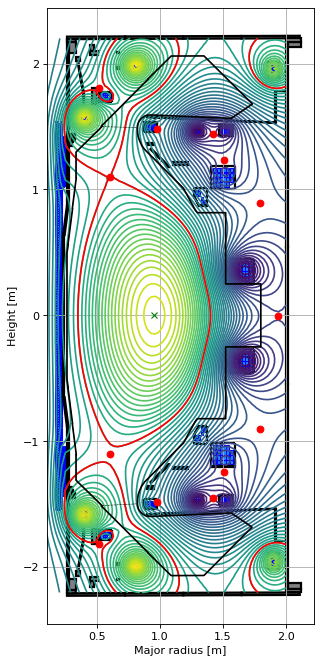

In [15]:
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles_Topeol, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)

Let's now use a Lao profile to set up the same identical equilibrium (Lao et al. 1985 NuclFus 25).
In Topeol's profile above both Pprime and FFprime terms are propto (1-x^2), which correspond to 
alpha \propto beta \propto (1,0,-1)
We also need to take into account that alpha/beta = mu0
Therefore we have 

In [16]:
from freegsnke.jtor_update import Lao85
from freegsfast.gradshafranov import mu0

alpha = np.array([1,0,-1])
beta = (1 - profiles_Topeol.Beta0)/profiles_Topeol.Beta0 * alpha * mu0

profiles_lao = Lao85(
    eq=eq_forward,
    limiter=tokamak.limiter,
    Ip=6e5,
    fvac=0.5,
    alpha=alpha,
    beta=beta,
    alpha_logic=False,
    beta_logic=False,
)

Note that above we're providing as input the full list of alpha and beta coefficients, and therefore setting to False both logic inputs.
The following is entirely equivalent to the above:

In [17]:
alpha = np.array([1,0])
beta = (1 - profiles_Topeol.Beta0)/profiles_Topeol.Beta0 * alpha * mu0

profiles_lao = Lao85(
    eq=eq_forward,
    limiter=tokamak.limiter,
    Ip=6e5,
    fvac=0.5,
    alpha=alpha,
    beta=beta,
    alpha_logic=True,
    beta_logic=True,
)

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

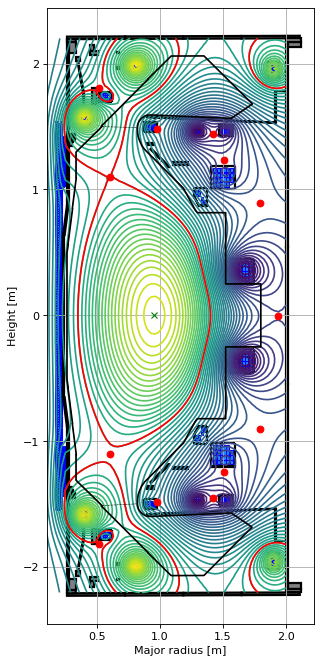

In [18]:
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles_lao, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq_forward.tokamak.plot(axis=ax,show=False)

The following illustrates that the two profile functions indeed generate the same current distribution.

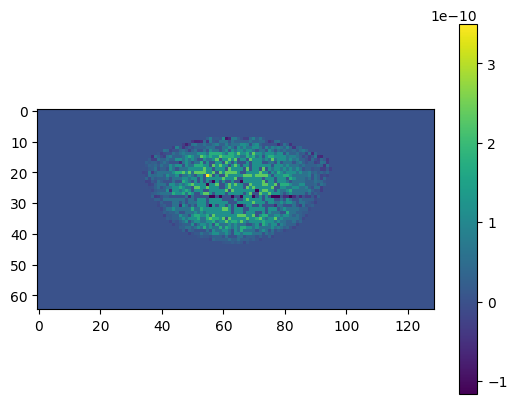

In [19]:
laoj = profiles_lao.Jtor(R=eq.R, Z=eq.Z, psi=eq_forward.psi())
topj = profiles_Topeol.Jtor(R=eq.R, Z=eq.Z, psi=eq_forward.psi())

plt.imshow(laoj-topj)
plt.colorbar()

FreeGSNKE Topeol profile allows to fit for the best set of Lao85 parameters, using the Lao_parameters method:

In [20]:
alpha, beta = profiles_Topeol.Lao_parameters(n_alpha=2, n_beta=2, alpha_logic=True, beta_logic=True)

In [21]:
profiles_lao_fit = Lao85(
    eq=eq_forward,
    limiter=tokamak.limiter,
    Ip=6e5,
    fvac=0.5,
    alpha=alpha,
    beta=beta,
    alpha_logic=True,
    beta_logic=True,
)

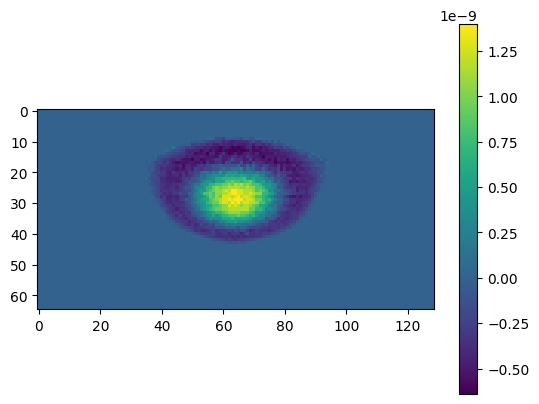

In [22]:
laoj = profiles_lao_fit.Jtor(R=eq.R, Z=eq.Z, psi=eq_forward.psi())
topj = profiles_Topeol.Jtor(R=eq.R, Z=eq.Z, psi=eq_forward.psi())

plt.imshow(laoj-topj)
plt.colorbar()

The reverse is also possible, using the Topeol_parameters method in the Lao85 profile object:

In [23]:
alpha_m, alpha_n, beta_0 = profiles_lao_fit.Topeol_parameters()
print(alpha_m, alpha_n, beta_0)

2.0000000837960576 1.000000024480739 0.36649999955878576
